In [186]:
%pylab inline
import matplotlib.pyplot as plt
import pandas as pd
import scipy.interpolate
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

data = pd.read_csv("wceGM12878_coveragewindows.bed", sep="\t", names=["chrom","start","end","resid","readcount"])

m = np.mean(data["readcount"])
s = np.sqrt(np.var(data["readcount"]))
print m, m+3*s, m-3*s

data = data[data["readcount"]<=m+3*s]

# Get zscore
def GetZscore(data, col):
    m = np.mean(data[col])
    s = np.sqrt(np.var(data[col]))
    return data.apply(lambda x: (x[col]-m)/s, 1)
data["zscore"] = GetZscore(data, "readcount")

# Restrict to region from mccarroll paper
Mb = 1000000
minval = 50
maxval = 90
data = data[(data["start"]>=minval*Mb) & (data["start"]<=maxval*Mb) ]

# Load Koren data
koren = pd.read_csv("data/Koren_etal_TableS2_hg19.bed", sep="\t", names=["chrom","start","end","zscore"])
koren = koren[(koren["chrom"]=="chr2") & (koren["start"]>=minval*Mb) & (koren["start"]<=maxval*Mb)]

Populating the interactive namespace from numpy and matplotlib
864.159785163 3815.58874751 -2087.26917718


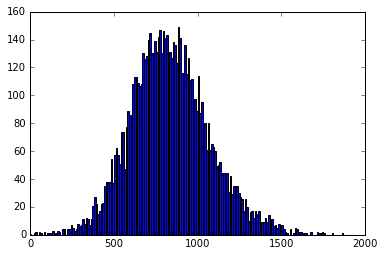

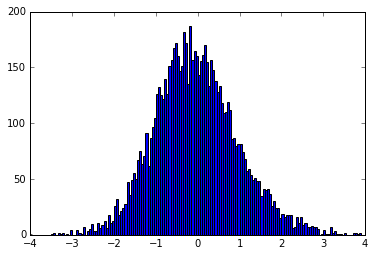

In [187]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(data["readcount"], bins=np.arange(0, 2000, 10));

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(data["zscore"], bins = np.arange(-4, 4, 0.05));

In [188]:
WINDOWSTEP=5000
def Smooth(data, windows=20, column="zscore", thin=10):
    newx = []
    newy = []
    # For each x, get +/- 10 windows
    for i in range(data.shape[0]):
        center = data.start.values[i]
        beginwindow = center - windows/2*WINDOWSTEP
        endwindow = center + (windows/2+1)*WINDOWSTEP
        x = data[(data["start"]>=beginwindow) & (data["end"]<=endwindow)]
        if x.shape[0] == windows:
            newx.append(center)
            newy.append(np.mean(x[column]))
        else:
            newx.append(np.nan)
            newy.append(np.nan)
    ind = [i for i in range(len(newx)) if i%thin == 0]
    return np.array(newx)[ind], np.array(newy)[ind]

In [189]:
xnew, ynew = Smooth(data, windows=100)

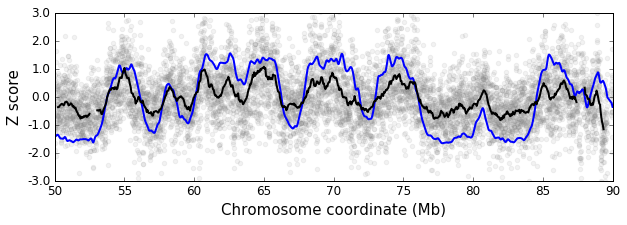

In [207]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches((10, 3))

# Plot koren
ax.plot(koren["start"], koren["zscore"], color="blue", lw=2)

# Plot wce gm12878
ax.plot(list(xnew), list(ynew), color="black", lw=2)
ax.scatter(data["start"], data["zscore"], color="gray", alpha=0.1)
ax.set_xlim(left=minval*Mb, right=maxval*Mb);
ax.set_ylim(bottom=-3, top=3)
ax.set_xlabel("Chromosome coordinate (Mb)", size=15);
ax.set_ylabel("Z-score", size=15);
ax.set_xticklabels(map(lambda x: int(x/Mb), ax.get_xticks()), size=12);
ax.set_yticklabels(ax.get_yticks(), size=12);
fig.savefig("wce_GM12878_ENCODE.pdf")